In [18]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.recurrent import LSTM
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [19]:
print(tf.__version__)
print(sys.version_info)
for module in np,pd,tf,tf.keras:
    print(module.__name__,module.__version__)

2.7.0
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
numpy 1.19.2
pandas 1.1.3
tensorflow 2.7.0
keras.api._v2.keras 2.7.0


In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 782524465323879978
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5734662144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9816268172226849408
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [21]:
try:
    # Disable all GPUS.
    # My model is very small so the overhead of transferring the data to the GPU and back to the CPU is less than the gain I would get.
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [22]:
# Loading dataset.
data = pd.read_excel('EVDS.xlsx', date_parser=[0])

# 5 data of dataset's head.
data.head()

,DATE,USD/TRY
0,01-01-2000,NaN
1,02-01-2000,NaN
2,03-01-2000,0.542703
3,04-01-2000,0.543401
4,05-01-2000,0.538399


In [23]:
# Making datetime
data['DATE'] = pd.to_datetime(data["DATE"], format='%d-%m-%Y')

# Set the index to date.
data.index = data["DATE"]
data.drop(["DATE"], axis=1, inplace=True)

In [24]:
# Filling null values with interpolate function.

data['USD/TRY'].interpolate(method='linear', inplace=True)

# The data in the null head is filled backwards.
data.fillna(method='bfill', inplace=True)

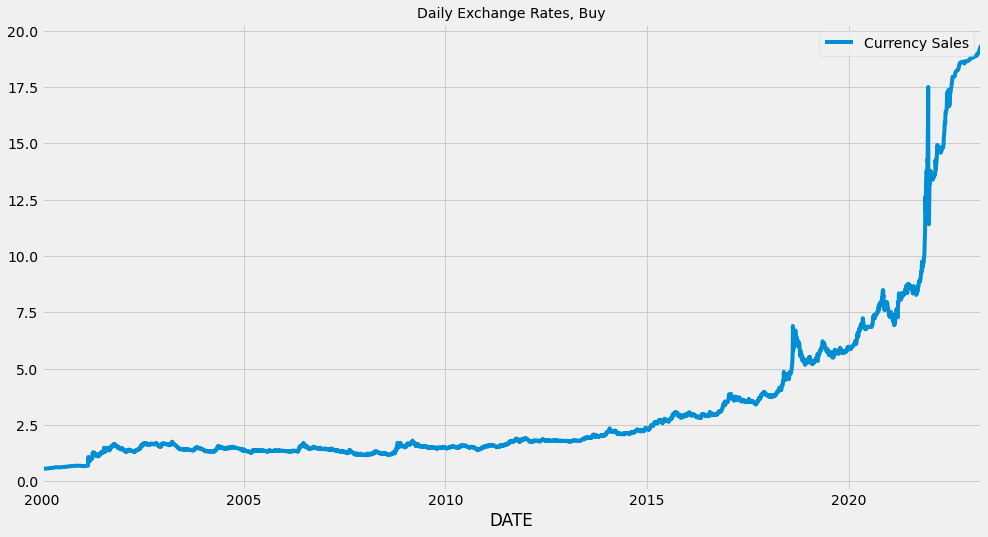

In [25]:
fig = plt.figure(figsize=(15,8))
data["USD/TRY"].plot(label='Currency Sales')
plt.legend(loc='best')
plt.title('Daily Exchange Rates, Buy', fontsize=14)
plt.show()

In [26]:
from sklearn.preprocessing import MinMaxScaler

values = data['USD/TRY'].values.reshape(-1,1)
values = values.astype('float32')
# Data scales from 0 to 1.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [27]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Distribution of data by sets (training, test): " + str((len(train), len(test))))

Distribution of data by sets (training, test): (5104, 3404)


In [28]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [29]:
# Preparing the dataset
window_size = 5
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print(f"Original training data shape: {train_X.shape}")

# Shape of final version of the dataset
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print(f"New training data shape: {train_X.shape}")

Original training data shape: (5098, 5)
New training data shape: (5098, 1, 5)


In [30]:
model = Sequential()

model.add(LSTM(128,
                activation="tanh",
                input_shape = (1, window_size)))
model.add(Dense(1))

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(loss = "mean_squared_error", 
                optimizer = "adam")

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               68608     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Fit the model.
history = model.fit(train_X, 
            train_Y, 
            epochs = 30,
            callbacks = [callbacks],
            batch_size = 32,
            shuffle=True,
            verbose = 1,
            validation_split=0.1)

Epoch 1/30
144/144 [==============================] - 2s 3ms/step - loss: 1.3665e-04 - val_loss: 3.6574e-05
Epoch 2/30
144/144 [==============================] - 0s 2ms/step - loss: 2.8772e-06 - val_loss: 4.3685e-07
Epoch 3/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0102e-06 - val_loss: 4.4230e-07
Epoch 4/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0299e-06 - val_loss: 5.1699e-07
Epoch 5/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0134e-06 - val_loss: 3.8357e-07
Epoch 6/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0365e-06 - val_loss: 4.0652e-07
Epoch 7/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0091e-06 - val_loss: 3.8215e-07
Epoch 8/30
144/144 [==============================] - 0s 2ms/step - loss: 1.0269e-06 - val_loss: 3.8253e-07
Epoch 9/30
144/144 [==============================] - 0s 2ms/step - loss: 9.9362e-07 - val_loss: 3.7235e-07
Epoch 10/30
144/144 [=======

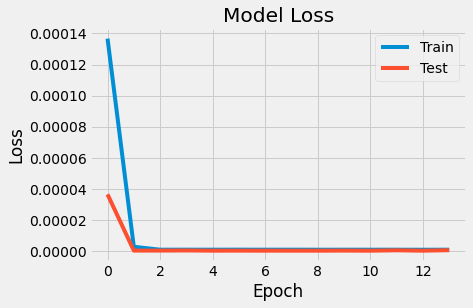

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [33]:
def predict_and_score(model, X, Y):
    # Predicted values are converted back to before scaling.
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    
    # Calculated RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(history.model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(history.model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.02 RMSE
Test data score: 0.16 RMSE


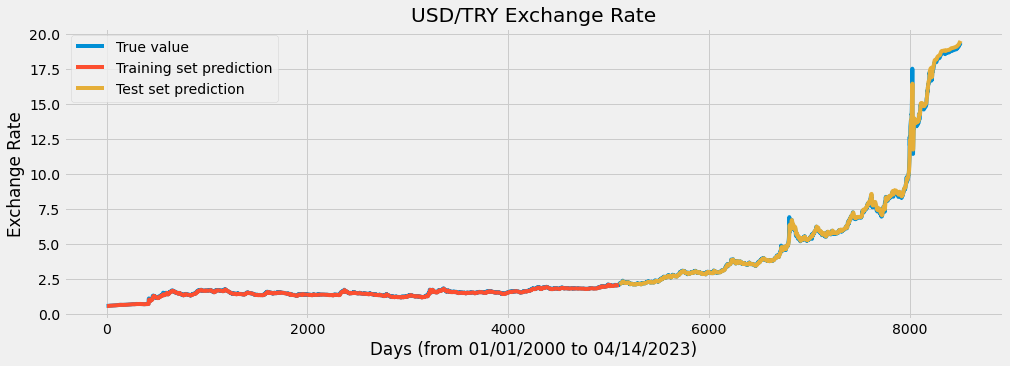

In [34]:
# Predicting of train dataset.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Predicting of test dataset.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Plot of results.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days (from 01/01/2000 to 04/14/2023)")
plt.ylabel("Exchange Rate")
plt.title("USD/TRY Exchange Rate")
plt.legend()
plt.show()